In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


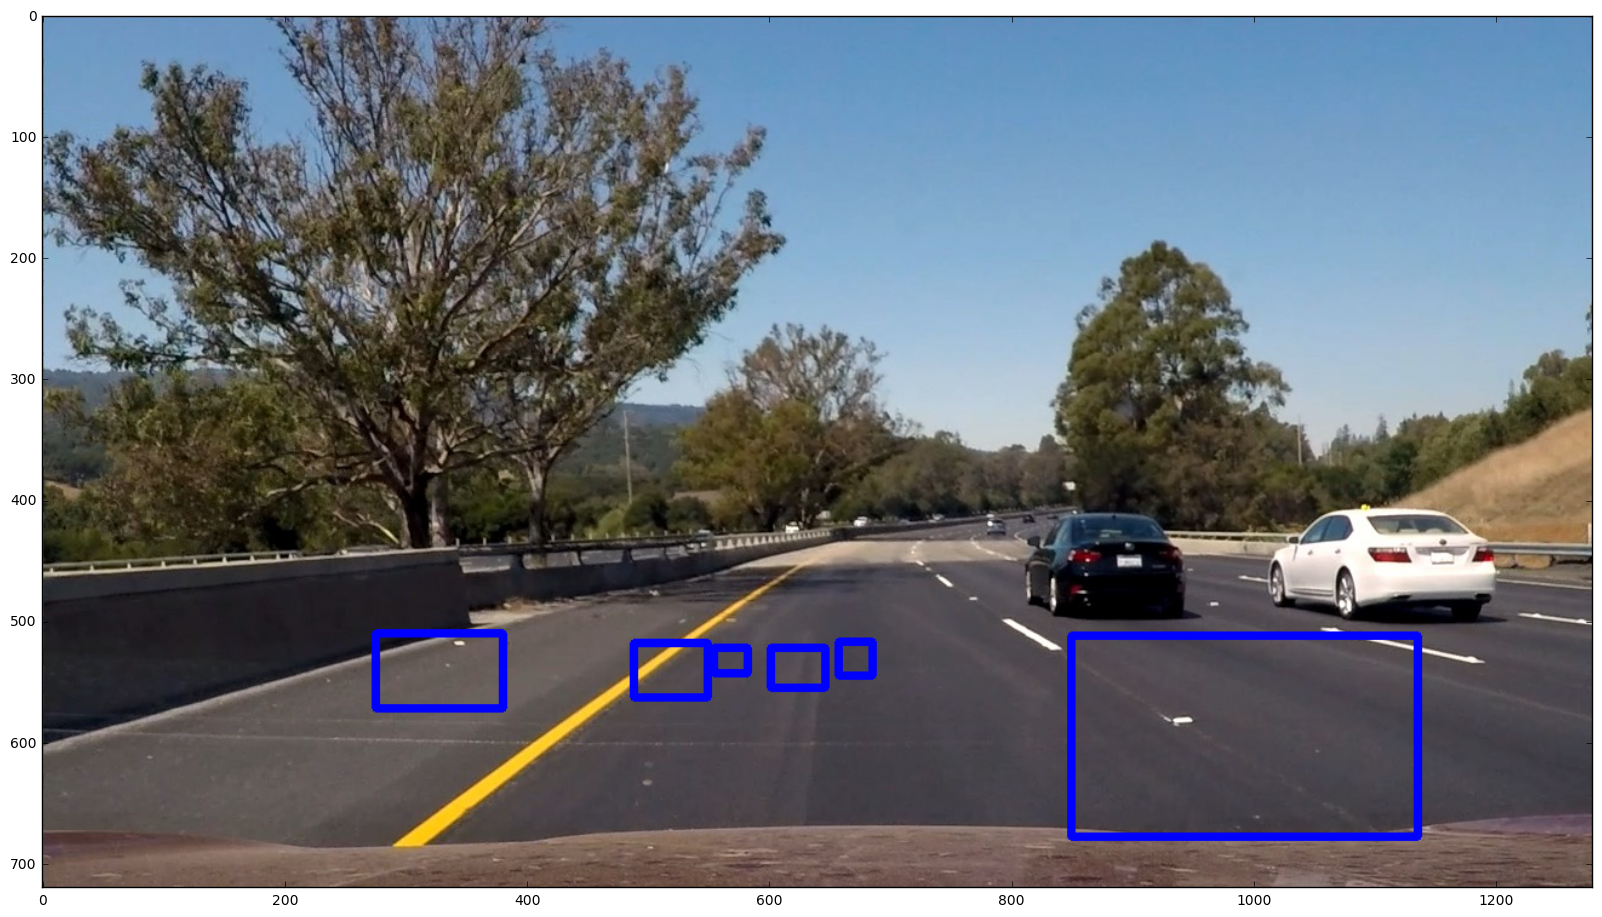

In [3]:

%matplotlib inline
image = mpimg.imread('test_images/test6.jpg')

#Box drawing
# Define a function that takes an image, a list of bounding boxes, 
# and optional color tuple and line thickness as inputs
# then draws boxes in that color on the output

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # make a copy of the image
    draw_img = np.copy(img)
    # draw each bounding box on your image copy using cv2.rectangle()
    for b in bboxes:
        cv2.rectangle(draw_img, b[0],b[1], color, thick)
    # return the image copy with boxes drawn
    return draw_img # Change this line to return image copy with boxes
# Add bounding boxes in this format, these are just example coordinates.
bboxes = [((275, 572), (380, 510)), ((488, 563), (549, 518)), ((554, 543), (582, 522)), 
          ((601, 555), (646, 522)), ((657, 545), (685, 517)), ((849, 678), (1135, 512))]


result = draw_boxes(image, bboxes)

plt.figure(figsize=(20,20))
plt.imshow(result)

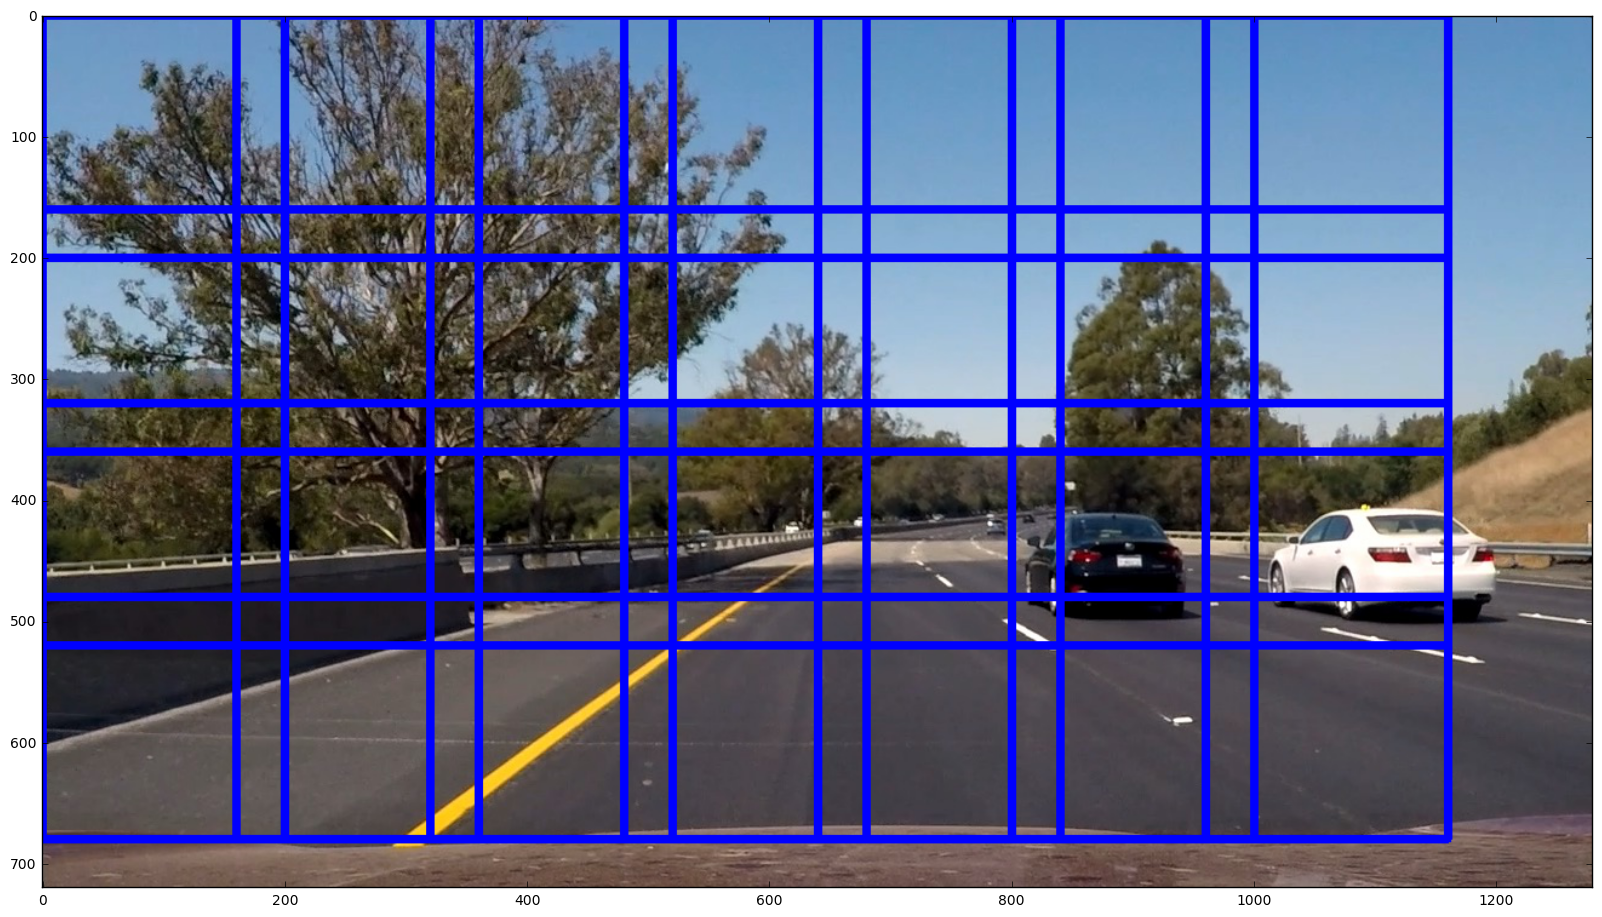

In [4]:
w_list = slide_window(image, x_start_stop=[0, 1280], y_start_stop=[0, 720], xy_window=(200,200), xy_overlap=(0.2, 0.2))
result = draw_boxes(image, w_list)

plt.figure(figsize=(20,20))
plt.imshow(result)

In [5]:
#Auxiliary functions

from skimage.feature import hog

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features



(720, 1280, 3)
(256, 1280, 3)


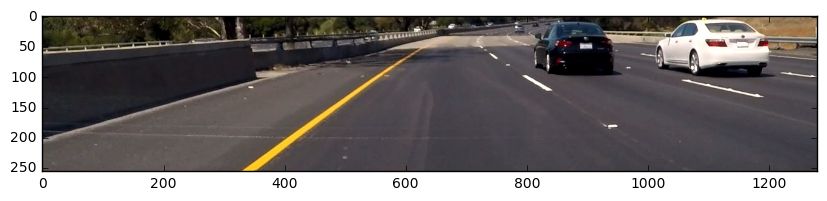

In [8]:
img = mpimg.imread('test_images/test6.jpg')
#draw_img = np.copy(img)
#img = img.astype(np.float32)/255

ystart = 400
ystop = 656
img_tosearch = img[400:656,:,:]
print(img.shape)
print(img_tosearch.shape)

plt.figure(figsize=(10,10))
plt.imshow(img_tosearch)
#img2 = convert_color(img, conv='RGB2YCrCb')
#print(img2.shape)



In [9]:
#HOG SUBSAMPLE
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from sklearn.preprocessing import StandardScaler

#svc = pickle.load( open("saved_svc.p", "rb" ) )
#X_scaler =pickle.load( open( "saved_X_scaler.p", "rb" ) )


# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc,  orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, cspace, X_scaler,showImage =True):
    count =0
    draw_img = np.copy(img)
    #img = img.astype(np.float32)/255
    boxes =[]
    
    img_tosearch = img[ystart:ystop,:,:]
    #print(ystart,ystop)
    #print('img', img.shape)
    #print('img_tosearch', img_tosearch.shape)
    
    #ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(img_tosearch)  
                    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    #nblocks_per_window = (window // pix_per_cell)-1 
    nblocks_per_window = (window // pix_per_cell)
    
    cells_per_step = 1  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            #print(yb ,' ypos ',ypos)
            #print(yb ,' ypos ',ypos+nblocks_per_window)
                            
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].reshape(1, -1)   
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].reshape(1, -1)   
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].reshape(1, -1)   
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            #subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

            # Get color features
            #spatial_features = bin_spatial(subimg, size=spatial_size)
            #hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            #test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #print('hog_features.shape',hog_features.shape)

            #X_scaler = StandardScaler().fit(hog_features)
            test_features = X_scaler.transform(hog_features).reshape(1, -1)   

            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)

            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                c1 =  np.random.randint(0, 255)
                c2 =  np.random.randint(0, 255)
                c3 =  np.random.randint(0, 255)
                count+=1
                if showImage==True:
                    cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(c1,c2,c3),6)              
                    cv2.putText(draw_img,str( count), (int(xbox_left),int(ytop_draw+ystart)), cv2.FONT_HERSHEY_SIMPLEX, 2,(255,255,255), 2,  lineType = cv2.LINE_AA)
                else:
                    if count>0:
                        boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))

    if showImage:
        return draw_img, count
    else:
        return boxes, count
 

In [10]:
#HOG SUBSAMPLE BOX ONLY
# Study of boxes positions
def find_cars_boxOnly(img, ystart, ystop, scale, svc,  orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, cspace, X_scaler,showImage =True):
    count=0
    draw_img = np.copy(img)
    #img = img.astype(np.float32)/255
    boxes =[]
    
    img_tosearch = img[ystart:ystop,:,:]
    #print(ystart,ystop)
    #print('img', img.shape)
    #print('img_tosearch', img_tosearch.shape)
    
    #ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    ctrans_tosearch = np.copy(img_tosearch)  
                    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    #nblocks_per_window = (window // pix_per_cell)-1 
    nblocks_per_window = (window // pix_per_cell)
    
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    #Plot only the diagonal
    for xb in range(nxsteps):
        yb = xb 
        ypos = yb*cells_per_step
        xpos = xb*cells_per_step

        xleft = xpos*pix_per_cell
        ytop = ypos*pix_per_cell

        xbox_left = np.int(xleft*scale)
        ytop_draw = np.int(ytop*scale)
        win_draw = np.int(window*scale)
        c1 =  np.random.randint(0, 255)
        c2 =  np.random.randint(0, 255)
        c3 =  np.random.randint(0, 255)
        count+=1

        cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(c1,c2,c3),6)              
        cv2.putText(draw_img,str( count), (int(xbox_left),int(ytop_draw+ystart)), cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255), 2,  lineType = cv2.LINE_AA)

        
    #Plot one value to the right
    xb = nxsteps
    yb= 0
    ypos = yb*cells_per_step
    xpos = xb*cells_per_step

    xleft = xpos*pix_per_cell
    ytop = ypos*pix_per_cell

    xbox_left = np.int(xleft*scale)
    ytop_draw = np.int(ytop*scale)
    win_draw = np.int(window*scale)
    c1 =  np.random.randint(0, 255)
    c2 =  np.random.randint(0, 255)
    c3 =  np.random.randint(0, 255)
    count+=1

    cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(c1,c2,c3),6)              
    cv2.putText(draw_img,str( count), (int(xbox_left),int(ytop_draw+ystart)), cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255), 2,  lineType = cv2.LINE_AA)


    return draw_img, count
 

In [ ]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog

# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', orient=8, 
                        pix_per_cell=8, cell_per_block=4, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
        
    # Return list of feature vectors
    return features

# Read in car and non-car images
cars = glob.glob('vehicles/**/*.png', recursive=True)
notcars = glob.glob('non-vehicles/**/*.png', recursive=True)

print('len(cars)', len(cars))
print('len(notcars)', len(notcars))
    
print(cars[0:4])



In [ ]:

%matplotlib inline

imageName =['image0038.png']

feat = extract_features(imageName, cspace='RGB', orient=8,pix_per_cell=8, cell_per_block=4, hog_channel='ALL')


image = mpimg.imread(imageName[0])
print(image.shape)

print('len(feat[0])',len(feat[0]))


### TODO: Tweak these parameters and see how the results change.
colorspace = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8
pix_per_cell = 8
cell_per_block = 1
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

t=time.time()
car_features = extract_features(cars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(notcars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)     
print('X.shape',X.shape)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')


In [ ]:
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 15
print('SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('Labels        ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

In [ ]:
print('X_train.shape',X_train.shape)

print('X_test.shape',X_test.shape)


In [ ]:
import pickle

pickle.dump( svc, open( "saved_svc.p", "wb" ) )
pickle.dump( svc, open( "saved_X_scaler.p", "wb" ) )

In [ ]:

loaded_svc = pickle.load( open( "saved_svc.p", "rb" ) )
loaded_X_scale = pickle.load( open( "saved_X_scaler.p", "rb" ) )

In [ ]:
print(loaded_svc)
print('Test Accuracy of original SVC = ', round(svc.score(X_test, y_test), 4))
print('Test Accuracy of pickled SVC = ', round(loaded_svc.score(X_test, y_test), 4))

print('Origin SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('Loaded SVC predicts: ', loaded_svc.predict(X_test[0:n_predict]))

In [11]:

svc = pickle.load( open("saved_svc_YCrCb.p", "rb" ) ) #Load svc
X_scaler = pickle.load( open("saved_X_scaler_YCrCb.p", "rb" ) ) #Load svc

#Test find_cars_boxOnly
ystart = 400
ystop = 656
scale = 1.5


orient = 8 #dist_pickle["orient"]
pix_per_cell = 8 #dist_pickle["pix_per_cell"]
cell_per_block = 1 # dist_pickle["cell_per_block"]
spatial_size = (32, 32) #dist_pickle["spatial_size"]
hist_bins = 32 # dist_pickle["hist_bins"]
cspace = 'YCrCb'
show = True
draw_img, count = find_cars_boxOnly(img, ystart, ystop, scale, svc, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, cspace, X_scaler,True)


print(count)
plt.figure(figsize=(10,10))
plt.imshow(draw_img)

FileNotFoundError: [Errno 2] No such file or directory: 'saved_svc_YCrCb.p'